In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [5]:
folder = os.path.join(data_dir,"dataset")

In [19]:
excluded = ["first_batch", "10x10_1mm_second_clean", "10x10_3mm_second_clean", "10x10_15mm_second_clean", 
            "10x10_20mm_second_clean", "10x10_30mm_second_clean", "10x10_35mm_second_clean",
            '10x10_15mm_third_clean', '10x10_1mm_third_clean', '10x10_20mm_third_clean',
            '10x10_30mm_third_clean', '10x10_35mm_third_clean', '10x10_3mm_third_clean']

In [21]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter, splitter_train_val_test

In [22]:
from DataSets import UNetDataSetFromNpz, UNetDatasetFromFolders

In [23]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [24]:
model_name = "../model/trained_cUNet_regression_validation_50epochs_coeff_mask0.75_batch16_on_npz.pkl"

In [25]:
model_inference = cUNet(out_size=1)

In [26]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [29]:
test_dataset = UNetDatasetFromFolders(folder, excluded=excluded, transform=composed)

In [30]:
len(test_dataset)

2400

In [31]:
data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [33]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 4, pred_dist: [4.017466]


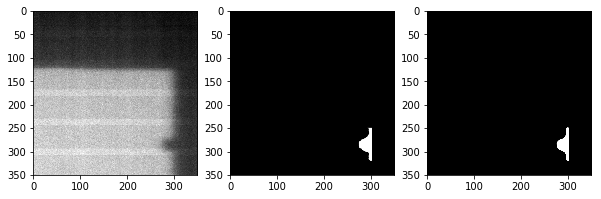

2: true_dist: 25, pred_dist: [25.135492]


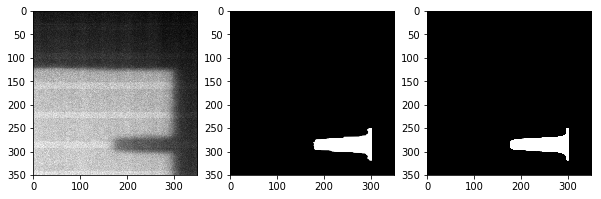

3: true_dist: 10, pred_dist: [9.747674]


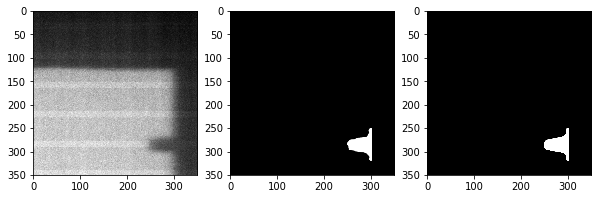

4: true_dist: 4, pred_dist: [3.8801758]


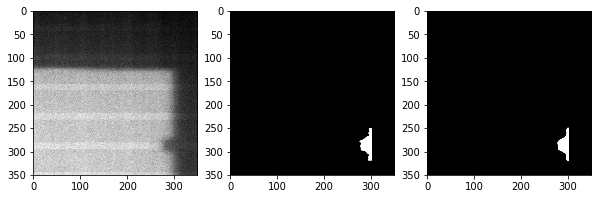

5: true_dist: 10, pred_dist: [9.884479]


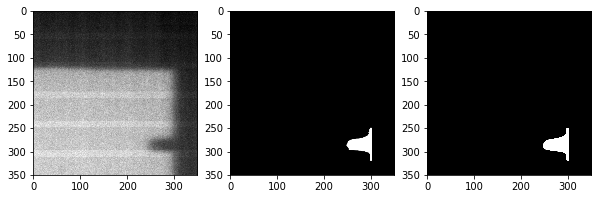

6: true_dist: 2, pred_dist: [1.8706217]


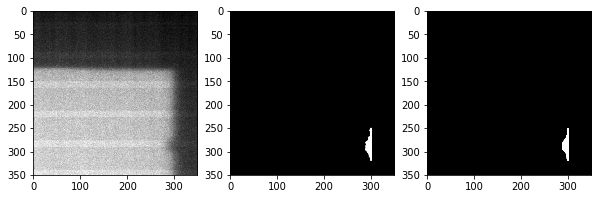

7: true_dist: 4, pred_dist: [4.024786]


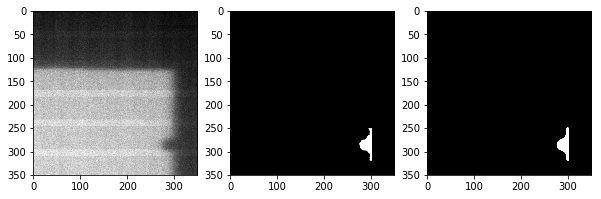

8: true_dist: 25, pred_dist: [24.977278]


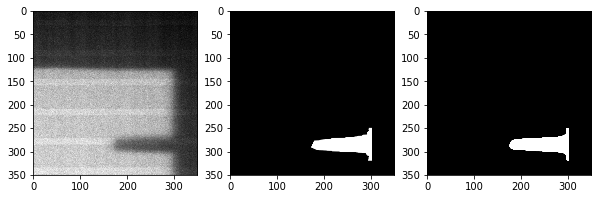

9: true_dist: 2, pred_dist: [2.0160246]


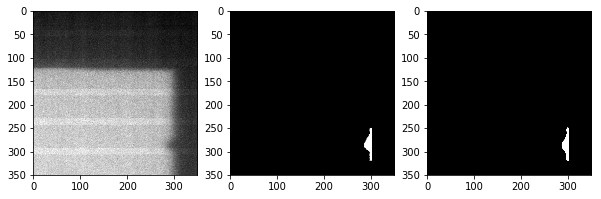

10: true_dist: 25, pred_dist: [24.950052]


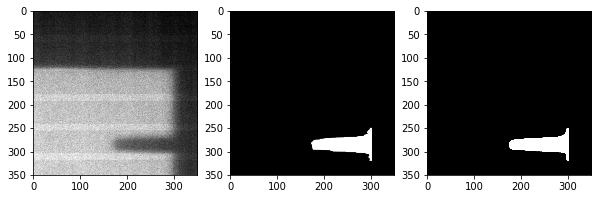

11: true_dist: 25, pred_dist: [24.858494]


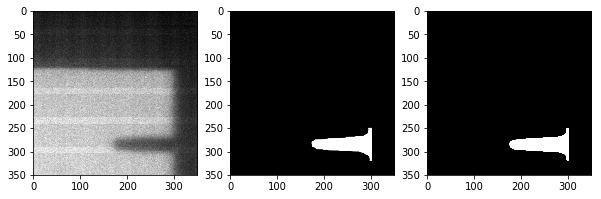

12: true_dist: 10, pred_dist: [9.43457]


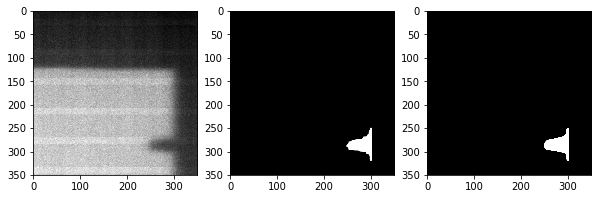

13: true_dist: 10, pred_dist: [9.570898]


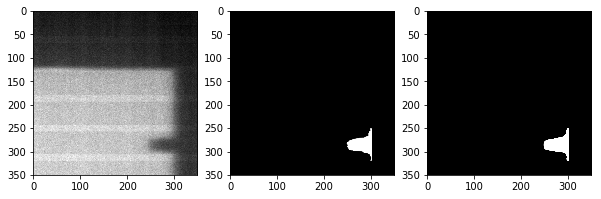

14: true_dist: 25, pred_dist: [24.828274]


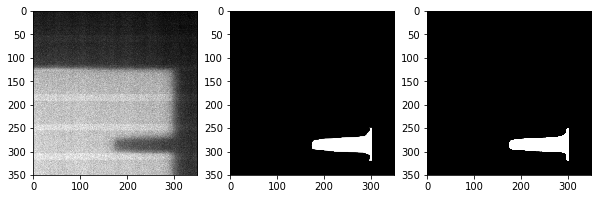

15: true_dist: 25, pred_dist: [25.102196]


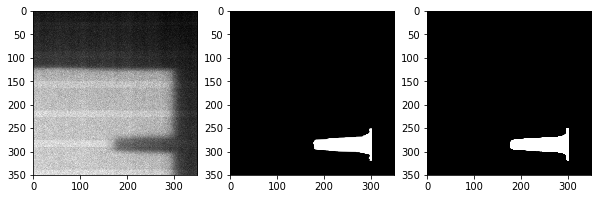

16: true_dist: 4, pred_dist: [3.990782]


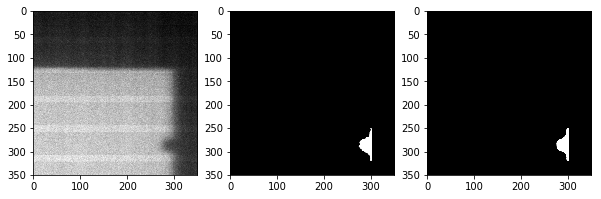

In [34]:
for i, batch in enumerate(data_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    break

In [35]:
y_true = []
y_pred = []

for i, batch in tqdm.tqdm(enumerate(data_loader)):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)


150it [04:07,  1.48s/it]


In [37]:
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred).ravel()
print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.03649701292272869


In [38]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [39]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [40]:
distances = [2,4,10,25]

In [41]:
errors = [idx_mse(i)[1] for i in distances]

2 0.013670774777158789
4 0.016859874870366696
10 0.07876675832976161
25 0.03669064371362765


In [42]:
np.savez_compressed(os.path.join(data_dir, "Predicted_2_4_10_25_ALL_out_model_trained_on_npz.npz"),
                   true = y_true, pred = y_pred)